---
title: "NeRF Exploration: Two-View Reconstruction of Pollen Grains"
author: "Nils Fahrni, Etienne Roulet"
date: "2025-03-28"
format:
  html:
    toc: true
    code-fold: true
    code-line-numbers: true
    embed-resources: true
    self-contained-math: true
  ipynb: default
jupyter: python3
---

# Abstract

abstract desc

# 1 Introduction

Text here

**Key questions**

- Text
- Text
- Text


# 2 Environment check

In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [2]:
def chamfer_distance(points1, points2):
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    d1, _ = tree1.query(points2)
    d2, _ = tree2.query(points1)
    return np.mean(d1**2) + np.mean(d2**2)

# 3 NeRF exploration

## Implementation



# Technische Zusammenfassung des NeRF‑Trainings mit lernbarer Translation

## 1. Setup und Datenvorbereitung
- **Imports & Logging**  
  PyTorch, NumPy, SciPy, skimage, trimesh, Matplotlib, `tqdm` u. a. werden geladen und CUDA‐Benchmarking aktiviert.
- **Datensatz**  
  Wenn verfügbar, wird `PollenDataset` importiert und in Trainings‑/Test‑Splits aufgeteilt.

## 2. Positional Encoding
- Koordinaten $x\in\mathbb R^3$ werden durch
  $$
    \bigl[x,\;\sin(2^i\pi x),\;\cos(2^i\pi x)\bigr]_{i=0}^{L-1}
  $$
  encodiert (mit $L=4$ statt klassisch 10), um Overfitting an hochfrequenten Signalen zu reduzieren.

## 3. NeRF‑Netzwerk
- **Architektur**  
  MLP mit $D=6$ versteckten Schichten, Breite $W=128$, Eingangs‑Dimension $3\,(2L+1)$, Ausgangs‑Dimension 4 $\bigl(R,G,B,\sigma\bigr)$.
- **Initialisierung**  
  Der Bias für die Dichte-Ausgabe $\sigma$ wird auf 0.1 gesetzt, um anfangs sichtbare Silhouetten zu ermöglichen.

## 4. Volumetrisches Rendering
- **Strahlen­abbildung**  
  Entlang jeder Kamera­strahl (Front- und Side‐View) werden $N\_samples$ Punkte im Intervall $[\mathrm{near},\mathrm{far}]$ abgefragt.
- **Alpha‐Compositing**  
  Aus den Dichten $\sigma$ werden Opazitäten $\alpha$ berechnet und Farbringen mit vorwärts akkumuliertem Transmittanz­term gewichtet.

## 5. Verlustfunktionen
1. **Photometric Loss**  
   Mittlerer quadratischer Fehler zwischen gerendertem Farb‑RGB und Ground‑Truth Pixeln.
2. **Silhouette Loss**  
   MSE zwischen Alpha‑Map und binärer Maske (Silhouette).
3. **Spherical Prior**  
   Zufällige Punkte im Würfel werden so bestraft, dass Dichte $\sigma$ nahe einer gewünschten Radius‑Kugel maximiert wird.
4. **Foreground Density Loss**  
   Strafen von zu geringen Dichten im Vordergrund (Maske).
5. **Smoothness Loss**  
   Finite-Differenzen‐Term auf $\sigma$, um lokale Glätte zu erzwingen.

## 6. Kamera‐Strahlen
- **`get_rays`**  
  Erzeugung von Front‑ und Side‐Kamerastrahlen in kanonischer Orientierung.
- **`rotate_rays`**  
  Anwenden der gegebenen Euler‑Rotation (in Grad) auf Strahlursprünge und ‑richtungen.

## 7. Lernbare Translationen
- **Parameter**  
  Zwei Vektoren `t_front`, `t_side` (`nn.Parameter(torch.zeros(3))` bzw. `[1,0,0]`).
- **Anwendung**  
  In jeder Trainingsiteration werden die Strahl‑Ursprünge um diese Translations‑Vektoren verschoben, und `t_front`/`t_side` gemeinsam mit dem NeRF‑Netz optimiert.

## 8. Weightedes Sampling
- **Motivation**  
  Mehr Samples an Kanten (Silhouette‑Ränder) und im Vordergrund, um Form und Kontur stärker zu gewichten.
- **Implementation**  
  Kantendetektion über 3×3‑Filter auf der binären Maske, Kombination mit Vordergrund‑Gewichten → Multinomial‑Sampling.

## 9. Trainingsschleife
- **Optimizer**  
  `Adam` auf alle `model.parameters()` + `[t_front, t_side]`.
- **Mixed Precision**  
  `torch.cuda.amp` für schnellere, speicherschonende Berechnungen.
- **Lernraten‑Scheduler**  
  `ReduceLROnPlateau` auf Gesamtloss.
- **Debug‐Renders**  
  Periodisch komplette Front/Side–RGB‑ und Alpha‐Bilder gespeichert, sowie Vergleich Ground‑Truth‑Maske vs. Alpha.

## 10. 3D‐Rekonstruktion
- **Volumendaten**  
  Aufgitterung des Raumbereichs, Auswertung von $\sigma$ für jedes Voxel.
- **Marching Cubes**  
  Extraktion der Iso‑Fläche bei Level ≈ Mittelwert + 0.3 Std, Export als STL.

## 11. Evaluation
- **Chamfer‑Distanz**  
  Vergleich der rekonstruierten Point‑Cloud (Stichprobe von Mesh) mit Ground‑Truth‑Pollen‑Punkten.

---

**Endergebnis:**  
Ein NeRF, das aus zwei Silhouetten‑Ansichten nicht nur Farbe und Dichte lernt, sondern gleichzeitig auch die Kameraposition (Translation) justiert und am Ende eine plausible 3D‑Geometrie des Pollenkorns extrahiert.


[SYS] Using device: cuda
[DATA] Loaded sample #86 → images: torch.Size([1, 1024, 1024]),torch.Size([1, 1024, 1024]); points: torch.Size([4000, 3]); rotations (rad): [42.67660903930664, 57.744712829589844, 296.34222412109375]; voxels: torch.Size([128, 128, 128])
[DATA] Image dimensions: 1024x1024


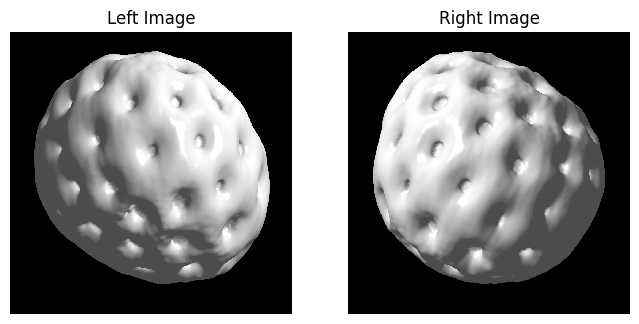

[TRAIN] Starting training ...


Training:   1%|          | 106/10000 [00:01<02:21, 70.05iter/s]

t_front= tensor([ 0.0304,  0.0046, -0.0366], device='cuda:0') t_side= tensor([ 0.0137, -0.0114,  0.0056], device='cuda:0')


Training:   2%|▏         | 210/10000 [00:03<02:24, 67.68iter/s]

t_front= tensor([ 0.0423,  0.0039, -0.0459], device='cuda:0') t_side= tensor([ 0.0082, -0.0024,  0.0058], device='cuda:0')
Iter 200: total=0.2136, photo=0.0134, sil=0.0400, shape=0.0455, dens=0.0000, smooth=0.0002
[TRAIN] ==> New best model saved.


Training:   3%|▎         | 304/10000 [00:04<02:16, 70.85iter/s]

t_front= tensor([ 0.0482,  0.0027, -0.0473], device='cuda:0') t_side= tensor([0.0009, 0.0027, 0.0074], device='cuda:0')


Training:   4%|▍         | 408/10000 [00:05<02:14, 71.25iter/s]

t_front= tensor([ 0.0363,  0.0095, -0.0471], device='cuda:0') t_side= tensor([0.0010, 0.0023, 0.0038], device='cuda:0')
Iter 400: total=0.1484, photo=0.0233, sil=0.0250, shape=0.2297, dens=0.0024, smooth=0.0134
[TRAIN] ==> New best model saved.


Training:   5%|▌         | 512/10000 [00:07<02:13, 71.19iter/s]

t_front= tensor([ 0.0371,  0.0125, -0.0537], device='cuda:0') t_side= tensor([0.0036, 0.0090, 0.0009], device='cuda:0')


Training:   6%|▌         | 608/10000 [00:08<02:10, 71.74iter/s]

t_front= tensor([ 0.0399,  0.0062, -0.0499], device='cuda:0') t_side= tensor([-0.0061,  0.0136,  0.0013], device='cuda:0')
Iter 600: total=0.0464, photo=0.0124, sil=0.0063, shape=0.5164, dens=0.0004, smooth=0.1163
[TRAIN] ==> New best model saved.


Training:   7%|▋         | 712/10000 [00:10<02:08, 72.41iter/s]

t_front= tensor([ 0.0414,  0.0024, -0.0497], device='cuda:0') t_side= tensor([-0.0061,  0.0093,  0.0031], device='cuda:0')


Training:   8%|▊         | 806/10000 [00:11<02:16, 67.32iter/s]

t_front= tensor([ 0.0423,  0.0038, -0.0498], device='cuda:0') t_side= tensor([-0.0124,  0.0113,  0.0052], device='cuda:0')
Iter 800: total=0.0336, photo=0.0101, sil=0.0043, shape=0.4994, dens=0.0000, smooth=0.0971
[TRAIN] ==> New best model saved.


Training:   9%|▉         | 909/10000 [00:12<02:06, 71.97iter/s]

t_front= tensor([ 0.0423,  0.0039, -0.0488], device='cuda:0') t_side= tensor([-0.0119,  0.0094,  0.0054], device='cuda:0')


Training:  10%|█         | 1005/10000 [00:14<02:04, 72.22iter/s]

t_front= tensor([ 0.0417,  0.0023, -0.0479], device='cuda:0') t_side= tensor([-0.0085,  0.0099,  0.0056], device='cuda:0')
Iter 1000: total=0.0648, photo=0.0090, sil=0.0108, shape=0.3943, dens=0.0026, smooth=0.0779


Training:  11%|█         | 1109/10000 [00:15<02:02, 72.58iter/s]

t_front= tensor([ 0.0415,  0.0027, -0.0483], device='cuda:0') t_side= tensor([-0.0100,  0.0088,  0.0046], device='cuda:0')


Training:  12%|█▏        | 1205/10000 [00:16<02:03, 71.46iter/s]

t_front= tensor([ 0.0423,  0.0045, -0.0471], device='cuda:0') t_side= tensor([-0.0093,  0.0094,  0.0038], device='cuda:0')
Iter 1200: total=0.0180, photo=0.0063, sil=0.0020, shape=0.3687, dens=0.0005, smooth=0.0792
[TRAIN] ==> New best model saved.


Training:  13%|█▎        | 1309/10000 [00:18<01:58, 73.33iter/s]

t_front= tensor([ 0.0412,  0.0040, -0.0471], device='cuda:0') t_side= tensor([-0.0108,  0.0090,  0.0040], device='cuda:0')


Training:  14%|█▍        | 1405/10000 [00:19<01:58, 72.74iter/s]

t_front= tensor([ 0.0409,  0.0033, -0.0466], device='cuda:0') t_side= tensor([-0.0103,  0.0104,  0.0047], device='cuda:0')
Iter 1400: total=0.0243, photo=0.0073, sil=0.0031, shape=0.3890, dens=0.0000, smooth=0.0822


Training:  15%|█▌        | 1509/10000 [00:21<01:55, 73.22iter/s]

t_front= tensor([ 0.0413,  0.0036, -0.0472], device='cuda:0') t_side= tensor([-0.0115,  0.0086,  0.0043], device='cuda:0')


Training:  16%|█▌        | 1605/10000 [00:22<01:56, 71.79iter/s]

t_front= tensor([ 0.0402,  0.0037, -0.0473], device='cuda:0') t_side= tensor([-0.0111,  0.0086,  0.0047], device='cuda:0')
Iter 1600: total=0.0223, photo=0.0051, sil=0.0031, shape=0.3413, dens=0.0000, smooth=0.0811


Training:  17%|█▋        | 1709/10000 [00:23<01:53, 73.02iter/s]

t_front= tensor([ 0.0404,  0.0035, -0.0478], device='cuda:0') t_side= tensor([-0.0119,  0.0085,  0.0044], device='cuda:0')


Training:  18%|█▊        | 1805/10000 [00:25<01:51, 73.25iter/s]

t_front= tensor([ 0.0402,  0.0042, -0.0480], device='cuda:0') t_side= tensor([-0.0111,  0.0074,  0.0044], device='cuda:0')
Iter 1800: total=0.0370, photo=0.0043, sil=0.0063, shape=0.3251, dens=0.0000, smooth=0.0711


Training:  19%|█▉        | 1909/10000 [00:26<01:51, 72.35iter/s]

t_front= tensor([ 0.0403,  0.0040, -0.0479], device='cuda:0') t_side= tensor([-0.0115,  0.0072,  0.0044], device='cuda:0')


Training:  20%|█▉        | 1996/10000 [00:27<01:49, 73.43iter/s]

t_front= tensor([ 0.0406,  0.0038, -0.0476], device='cuda:0') t_side= tensor([-0.0114,  0.0072,  0.0045], device='cuda:0')
Iter 2000: total=0.0249, photo=0.0062, sil=0.0035, shape=0.3459, dens=0.0000, smooth=0.0709
[DEBUG] Rendering images at iteration 2000 ...
[DEBUG RENDER] Saved front images at iter 2000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 2000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 2000 in debug_renders/


Training:  20%|██        | 2012/10000 [00:40<44:53,  2.97iter/s]  

[DEBUG] Saved mask-vs-alpha comparison for side at iter 2000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_2000.pth



Training:  21%|██        | 2107/10000 [00:41<02:25, 54.38iter/s]

t_front= tensor([ 0.0405,  0.0034, -0.0468], device='cuda:0') t_side= tensor([-0.0118,  0.0076,  0.0047], device='cuda:0')


Training:  22%|██▏       | 2211/10000 [00:43<01:50, 70.46iter/s]

t_front= tensor([ 0.0406,  0.0037, -0.0475], device='cuda:0') t_side= tensor([-0.0113,  0.0072,  0.0046], device='cuda:0')
Iter 2200: total=0.0160, photo=0.0037, sil=0.0022, shape=0.3556, dens=0.0000, smooth=0.0690
[TRAIN] ==> New best model saved.


Training:  23%|██▎       | 2307/10000 [00:44<01:46, 72.57iter/s]

t_front= tensor([ 0.0404,  0.0038, -0.0476], device='cuda:0') t_side= tensor([-0.0109,  0.0073,  0.0049], device='cuda:0')


Training:  24%|██▍       | 2411/10000 [00:45<01:43, 73.18iter/s]

t_front= tensor([ 0.0403,  0.0037, -0.0478], device='cuda:0') t_side= tensor([-0.0114,  0.0072,  0.0048], device='cuda:0')
Iter 2400: total=0.0180, photo=0.0049, sil=0.0023, shape=0.3511, dens=0.0007, smooth=0.0874


Training:  25%|██▌       | 2507/10000 [00:47<01:45, 71.18iter/s]

t_front= tensor([ 0.0401,  0.0037, -0.0474], device='cuda:0') t_side= tensor([-0.0115,  0.0066,  0.0047], device='cuda:0')


Training:  26%|██▌       | 2611/10000 [00:48<01:41, 72.85iter/s]

t_front= tensor([ 0.0402,  0.0037, -0.0478], device='cuda:0') t_side= tensor([-0.0110,  0.0064,  0.0047], device='cuda:0')
Iter 2600: total=0.0261, photo=0.0041, sil=0.0041, shape=0.3446, dens=0.0000, smooth=0.0730


Training:  27%|██▋       | 2707/10000 [00:50<01:45, 69.20iter/s]

t_front= tensor([ 0.0401,  0.0036, -0.0475], device='cuda:0') t_side= tensor([-0.0115,  0.0070,  0.0043], device='cuda:0')


Training:  28%|██▊       | 2811/10000 [00:51<01:41, 70.71iter/s]

t_front= tensor([ 0.0400,  0.0040, -0.0474], device='cuda:0') t_side= tensor([-0.0114,  0.0070,  0.0046], device='cuda:0')
Iter 2800: total=0.0226, photo=0.0042, sil=0.0034, shape=0.3445, dens=0.0000, smooth=0.0718


Training:  29%|██▉       | 2915/10000 [00:53<01:37, 72.92iter/s]

t_front= tensor([ 0.0402,  0.0039, -0.0475], device='cuda:0') t_side= tensor([-0.0109,  0.0065,  0.0049], device='cuda:0')


Training:  30%|███       | 3011/10000 [00:54<01:36, 72.62iter/s]

t_front= tensor([ 0.0402,  0.0038, -0.0476], device='cuda:0') t_side= tensor([-0.0112,  0.0064,  0.0045], device='cuda:0')
Iter 3000: total=0.0061, photo=0.0034, sil=0.0003, shape=0.3564, dens=0.0000, smooth=0.0693
[TRAIN] ==> New best model saved.


Training:  31%|███       | 3107/10000 [00:55<01:35, 72.40iter/s]

t_front= tensor([ 0.0402,  0.0037, -0.0476], device='cuda:0') t_side= tensor([-0.0113,  0.0066,  0.0046], device='cuda:0')


Training:  32%|███▏      | 3211/10000 [00:57<01:32, 73.69iter/s]

t_front= tensor([ 0.0401,  0.0037, -0.0476], device='cuda:0') t_side= tensor([-0.0116,  0.0065,  0.0046], device='cuda:0')
Iter 3200: total=0.0273, photo=0.0037, sil=0.0044, shape=0.3329, dens=0.0000, smooth=0.0758


Training:  33%|███▎      | 3307/10000 [00:58<01:30, 73.88iter/s]

t_front= tensor([ 0.0401,  0.0039, -0.0475], device='cuda:0') t_side= tensor([-0.0117,  0.0064,  0.0046], device='cuda:0')


Training:  34%|███▍      | 3411/10000 [00:59<01:29, 73.22iter/s]

t_front= tensor([ 0.0400,  0.0040, -0.0472], device='cuda:0') t_side= tensor([-0.0118,  0.0065,  0.0045], device='cuda:0')
Iter 3400: total=0.0196, photo=0.0036, sil=0.0029, shape=0.3495, dens=0.0000, smooth=0.0681


Training:  35%|███▌      | 3507/10000 [01:01<01:28, 73.08iter/s]

t_front= tensor([ 0.0400,  0.0039, -0.0473], device='cuda:0') t_side= tensor([-0.0117,  0.0064,  0.0045], device='cuda:0')


Training:  36%|███▌      | 3611/10000 [01:02<01:28, 72.41iter/s]

t_front= tensor([ 0.0400,  0.0039, -0.0473], device='cuda:0') t_side= tensor([-0.0116,  0.0063,  0.0045], device='cuda:0')
Iter 3600: total=0.0291, photo=0.0039, sil=0.0047, shape=0.3507, dens=0.0000, smooth=0.0846


Training:  37%|███▋      | 3707/10000 [01:03<01:25, 74.00iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0116,  0.0064,  0.0045], device='cuda:0')


Training:  38%|███▊      | 3811/10000 [01:05<01:24, 73.31iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0474], device='cuda:0') t_side= tensor([-0.0116,  0.0064,  0.0047], device='cuda:0')
Iter 3800: total=0.0174, photo=0.0035, sil=0.0025, shape=0.3645, dens=0.0000, smooth=0.0788


Training:  39%|███▉      | 3907/10000 [01:06<01:24, 72.14iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0064,  0.0046], device='cuda:0')


Training:  40%|███▉      | 3994/10000 [01:07<01:22, 72.89iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0063,  0.0046], device='cuda:0')
Iter 4000: total=0.0078, photo=0.0039, sil=0.0005, shape=0.3611, dens=0.0000, smooth=0.0737
[DEBUG] Rendering images at iteration 4000 ...
[DEBUG RENDER] Saved front images at iter 4000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 4000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 4000 in debug_renders/


Training:  40%|████      | 4010/10000 [01:20<33:54,  2.94iter/s]

[DEBUG] Saved mask-vs-alpha comparison for side at iter 4000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_4000.pth



Training:  41%|████      | 4106/10000 [01:21<01:47, 54.77iter/s]

t_front= tensor([ 0.0400,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0116,  0.0063,  0.0046], device='cuda:0')


Training:  42%|████▏     | 4210/10000 [01:23<01:23, 69.68iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0116,  0.0063,  0.0046], device='cuda:0')
Iter 4200: total=0.0267, photo=0.0036, sil=0.0043, shape=0.3594, dens=0.0000, smooth=0.0847


Training:  43%|████▎     | 4306/10000 [01:24<01:17, 73.44iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0116,  0.0063,  0.0046], device='cuda:0')


Training:  44%|████▍     | 4410/10000 [01:26<01:16, 73.36iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0116,  0.0063,  0.0046], device='cuda:0')
Iter 4400: total=0.0181, photo=0.0039, sil=0.0025, shape=0.3318, dens=0.0000, smooth=0.0751


Training:  45%|████▌     | 4506/10000 [01:27<01:17, 70.58iter/s]

t_front= tensor([ 0.0400,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  46%|████▌     | 4610/10000 [01:28<01:14, 72.24iter/s]

t_front= tensor([ 0.0400,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 4600: total=0.0272, photo=0.0041, sil=0.0043, shape=0.3128, dens=0.0000, smooth=0.0801


Training:  47%|████▋     | 4706/10000 [01:30<01:11, 74.06iter/s]

t_front= tensor([ 0.0399,  0.0039, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  48%|████▊     | 4810/10000 [01:31<01:12, 71.52iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 4800: total=0.0150, photo=0.0028, sil=0.0022, shape=0.3586, dens=0.0000, smooth=0.0679


Training:  49%|████▉     | 4906/10000 [01:32<01:10, 72.05iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  50%|█████     | 5010/10000 [01:34<01:08, 72.78iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 5000: total=0.0166, photo=0.0039, sil=0.0022, shape=0.3430, dens=0.0000, smooth=0.0786


Training:  51%|█████     | 5106/10000 [01:35<01:07, 72.34iter/s]

t_front= tensor([ 0.0400,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  52%|█████▏    | 5210/10000 [01:37<01:06, 72.55iter/s]

t_front= tensor([ 0.0400,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 5200: total=0.0115, photo=0.0032, sil=0.0014, shape=0.3249, dens=0.0000, smooth=0.0717


Training:  53%|█████▎    | 5306/10000 [01:38<01:04, 73.02iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  54%|█████▍    | 5410/10000 [01:39<01:03, 72.26iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 5400: total=0.0095, photo=0.0031, sil=0.0010, shape=0.3788, dens=0.0003, smooth=0.0675


Training:  55%|█████▌    | 5506/10000 [01:41<01:01, 72.62iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  56%|█████▌    | 5610/10000 [01:42<00:59, 73.36iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 5600: total=0.0207, photo=0.0034, sil=0.0032, shape=0.3202, dens=0.0000, smooth=0.0725


Training:  57%|█████▋    | 5705/10000 [01:43<00:59, 72.10iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  58%|█████▊    | 5809/10000 [01:45<00:57, 73.45iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 5800: total=0.0127, photo=0.0042, sil=0.0014, shape=0.2917, dens=0.0000, smooth=0.0751


Training:  59%|█████▉    | 5912/10000 [01:46<00:56, 72.58iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  60%|█████▉    | 5999/10000 [01:48<00:54, 73.46iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 6000: total=0.0122, photo=0.0038, sil=0.0014, shape=0.3334, dens=0.0000, smooth=0.0731
[DEBUG] Rendering images at iteration 6000 ...
[DEBUG RENDER] Saved front images at iter 6000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 6000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 6000 in debug_renders/


Training:  60%|██████    | 6007/10000 [02:00<32:02,  2.08iter/s]

[DEBUG] Saved mask-vs-alpha comparison for side at iter 6000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_6000.pth



Training:  61%|██████    | 6109/10000 [02:02<01:11, 54.35iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  62%|██████▏   | 6212/10000 [02:03<00:54, 68.97iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 6200: total=0.0151, photo=0.0043, sil=0.0019, shape=0.3390, dens=0.0000, smooth=0.0724


Training:  63%|██████▎   | 6308/10000 [02:04<00:50, 72.71iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  64%|██████▍   | 6412/10000 [02:06<00:49, 72.69iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 6400: total=0.0250, photo=0.0038, sil=0.0039, shape=0.3617, dens=0.0000, smooth=0.0737


Training:  65%|██████▌   | 6508/10000 [02:07<00:48, 72.00iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  66%|██████▌   | 6612/10000 [02:09<00:46, 72.97iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 6600: total=0.0166, photo=0.0036, sil=0.0023, shape=0.3458, dens=0.0000, smooth=0.0796


Training:  67%|██████▋   | 6708/10000 [02:10<00:44, 74.13iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  68%|██████▊   | 6804/10000 [02:11<00:44, 71.94iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 6800: total=0.0166, photo=0.0032, sil=0.0024, shape=0.3600, dens=0.0000, smooth=0.0739


Training:  69%|██████▉   | 6908/10000 [02:13<00:42, 73.49iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  70%|███████   | 7004/10000 [02:14<00:41, 72.85iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 7000: total=0.0166, photo=0.0038, sil=0.0022, shape=0.3480, dens=0.0000, smooth=0.0828


Training:  71%|███████   | 7108/10000 [02:15<00:39, 72.68iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  72%|███████▏  | 7212/10000 [02:17<00:38, 72.41iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 7200: total=0.0206, photo=0.0032, sil=0.0031, shape=0.3419, dens=0.0000, smooth=0.0808


Training:  73%|███████▎  | 7308/10000 [02:18<00:36, 73.33iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  74%|███████▍  | 7412/10000 [02:20<00:35, 72.60iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 7400: total=0.0234, photo=0.0038, sil=0.0037, shape=0.3391, dens=0.0000, smooth=0.0650


Training:  75%|███████▌  | 7508/10000 [02:21<00:34, 72.55iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  76%|███████▌  | 7612/10000 [02:22<00:32, 72.74iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 7600: total=0.0113, photo=0.0033, sil=0.0013, shape=0.3570, dens=0.0000, smooth=0.0680


Training:  77%|███████▋  | 7707/10000 [02:24<00:31, 72.72iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  78%|███████▊  | 7803/10000 [02:25<00:30, 72.27iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 7800: total=0.0158, photo=0.0032, sil=0.0022, shape=0.3214, dens=0.0000, smooth=0.0820


Training:  79%|███████▉  | 7911/10000 [02:27<00:28, 72.53iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  80%|███████▉  | 7998/10000 [02:28<00:27, 73.95iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 8000: total=0.0157, photo=0.0038, sil=0.0021, shape=0.3266, dens=0.0000, smooth=0.0613
[DEBUG] Rendering images at iteration 8000 ...
[DEBUG RENDER] Saved front images at iter 8000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 8000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 8000 in debug_renders/


Training:  80%|████████  | 8006/10000 [02:40<15:53,  2.09iter/s]

[DEBUG] Saved mask-vs-alpha comparison for side at iter 8000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_8000.pth



Training:  81%|████████  | 8109/10000 [02:42<00:34, 54.80iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  82%|████████▏ | 8213/10000 [02:43<00:25, 70.97iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 8200: total=0.0189, photo=0.0035, sil=0.0028, shape=0.3566, dens=0.0000, smooth=0.0747


Training:  83%|████████▎ | 8309/10000 [02:44<00:22, 73.57iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  84%|████████▍ | 8405/10000 [02:46<00:21, 73.04iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 8400: total=0.0179, photo=0.0032, sil=0.0027, shape=0.3386, dens=0.0000, smooth=0.0735


Training:  85%|████████▌ | 8509/10000 [02:47<00:20, 72.33iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  86%|████████▌ | 8605/10000 [02:49<00:19, 72.97iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 8600: total=0.0159, photo=0.0031, sil=0.0022, shape=0.3439, dens=0.0000, smooth=0.0810


Training:  87%|████████▋ | 8709/10000 [02:50<00:17, 73.11iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  88%|████████▊ | 8805/10000 [02:51<00:16, 71.95iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 8800: total=0.0198, photo=0.0046, sil=0.0028, shape=0.3194, dens=0.0000, smooth=0.0704


Training:  89%|████████▉ | 8909/10000 [02:53<00:14, 73.54iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  90%|█████████ | 9005/10000 [02:54<00:13, 72.24iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 9000: total=0.0196, photo=0.0041, sil=0.0027, shape=0.3337, dens=0.0000, smooth=0.0856


Training:  91%|█████████ | 9109/10000 [02:55<00:12, 72.95iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  92%|█████████▏| 9205/10000 [02:57<00:10, 72.84iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 9200: total=0.0112, photo=0.0036, sil=0.0012, shape=0.3441, dens=0.0000, smooth=0.0791


Training:  93%|█████████▎| 9309/10000 [02:58<00:09, 72.64iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  94%|█████████▍| 9405/10000 [03:00<00:08, 72.93iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 9400: total=0.0154, photo=0.0037, sil=0.0020, shape=0.3669, dens=0.0000, smooth=0.0857


Training:  95%|█████████▌| 9509/10000 [03:01<00:06, 72.36iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  96%|█████████▌| 9605/10000 [03:02<00:05, 73.20iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 9600: total=0.0318, photo=0.0040, sil=0.0053, shape=0.3542, dens=0.0000, smooth=0.0772


Training:  97%|█████████▋| 9709/10000 [03:04<00:03, 73.20iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training:  98%|█████████▊| 9805/10000 [03:05<00:02, 71.28iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 9800: total=0.0235, photo=0.0032, sil=0.0038, shape=0.3476, dens=0.0000, smooth=0.0790


Training:  99%|█████████▉| 9908/10000 [03:07<00:01, 72.32iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')


Training: 100%|█████████▉| 9996/10000 [03:08<00:00, 73.51iter/s]

t_front= tensor([ 0.0399,  0.0040, -0.0473], device='cuda:0') t_side= tensor([-0.0115,  0.0062,  0.0046], device='cuda:0')
Iter 10000: total=0.0120, photo=0.0035, sil=0.0014, shape=0.3596, dens=0.0000, smooth=0.0803
[DEBUG] Rendering images at iteration 10000 ...
[DEBUG RENDER] Saved front images at iter 10000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 10000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 10000 in debug_renders/


Training: 100%|██████████| 10000/10000 [03:20<00:00, 49.82iter/s]

[DEBUG] Saved mask-vs-alpha comparison for side at iter 10000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_10000.pth

[TRAIN] Done.

[EXTRACT 3D] Running marching cubes...


  Sigma volume stats: min=0.0000, max=16.3347, mean=2.1199, std=3.1860
  Using iso-level=7.5080
  --> Saved mesh to nerf_reconstruction.stl

[RESULT] Chamfer Dist (Pred vs. GT point‐cloud): 1740.784123

Done.


In [ ]:
import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import trimesh

# If you have the data package
sys.path.append("..")
try:
    from data.pollen_dataset import PollenDataset, get_train_test_split
except ImportError:
    # Fallback if not available
    PollenDataset = None
    get_train_test_split = None

torch.backends.cudnn.benchmark = True

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


################################################################################
# 1. Positional Encoding (Reduced Frequencies)
################################################################################
def positional_encoding(x, L=4):
    """
    Encode coordinates x with sine/cosine functions at increasing frequencies.
    We use L=4 here (fewer than the classic L=10) to reduce high-frequency overfitting.
    """
    out = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * np.pi * x))
    return torch.cat(out, dim=-1)


################################################################################
# 2. NeRF Model with Reduced Positional Encoding
################################################################################
class NeRF(nn.Module):
    def __init__(self, D=6, W=128, L=4):
        """
        Args:
            D: Number of hidden layers
            W: Number of hidden units per layer
            L: Positional encoding frequency levels
        """
        super(NeRF, self).__init__()
        self.L = L
        in_channels = 3 * (2 * L + 1)  # 3 coords * (2L + 1)

        layers = []
        layers.append(nn.Linear(in_channels, W))
        for _ in range(D - 1):
            layers.append(nn.Linear(W, W))

        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(W, 4)

        # Initialize sigma bias to something non-zero
        with torch.no_grad():
            self.output_layer.bias[3] = 0.1

    def forward(self, x):
        """
        Forward pass: x is (N, 3), output is (N, 4) => [R, G, B, sigma].
        """
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for layer in self.layers:
            h = torch.relu(layer(h))
        return self.output_layer(h)


################################################################################
# 3. Render Rays (RGB + Alpha)
################################################################################
def render_rays(
    model, rays_o, rays_d, near=0.5, far=1.5, N_samples=128, sigma_scale=1.0
):
    """
    Volumetric rendering for a batch of rays:
      - Sample points along each ray
      - Query MLP for color (rgb) and density (sigma)
      - Composite color and alpha
    """
    device = rays_o.device
    z_vals = torch.linspace(near, far, N_samples, device=device)

    pts = (
        rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    )  # (B, N_samples, 3)
    pts_flat = pts.reshape(-1, 3)

    raw = model(pts_flat).reshape(pts.shape[0], N_samples, 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3]) * sigma_scale

    deltas = z_vals[1:] - z_vals[:-1]
    deltas = torch.cat([deltas, torch.tensor([1e10], device=device)])
    deltas = deltas[None, :].expand(sigma.shape)

    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(
        torch.cat(
            [torch.ones((sigma.shape[0], 1), device=device), 1.0 - alpha + 1e-10],
            dim=-1,
        ),
        dim=-1,
    )[:, :-1]
    weights = alpha * T

    rgb_map = torch.sum(weights[..., None] * rgb, dim=1)
    alpha_map = torch.sum(weights, dim=1)
    return rgb_map, alpha_map


################################################################################
# 4. Losses: Silhouette, Spherical Prior, etc.
################################################################################
def silhouette_loss(alpha_map, mask):
    return torch.mean((alpha_map - mask) ** 2)


def spherical_prior_loss(
    model, num_samples=2000, bound=1.0, desired_radius=0.6, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound

    raw = model(coords)
    sigma = torch.relu(raw[..., 3]) * sigma_scale
    dists = torch.norm(coords, dim=1)
    # Encourage high sigma near the desired radius
    loss = torch.mean(sigma * (dists - desired_radius) ** 2)
    return loss


def foreground_density_loss(alpha_map, mask, target_density=1.0):
    eps = 1e-6
    D = -torch.log(1.0 - alpha_map + eps)
    fg_mask = mask > 0.5
    if torch.sum(fg_mask) > 0:
        return torch.mean(torch.clamp(target_density - D[fg_mask], min=0.0))
    else:
        return torch.tensor(0.0, device=alpha_map.device)


def smoothness_prior_loss(
    model, num_samples=2000, bound=1.0, offset=0.01, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound

    raw_center = model(coords)
    sigma_center = torch.relu(raw_center[..., 3]) * sigma_scale

    offsets = torch.tensor(
        [
            [offset, 0, 0],
            [-offset, 0, 0],
            [0, offset, 0],
            [0, -offset, 0],
            [0, 0, offset],
            [0, 0, -offset],
        ],
        device=device,
    ).float()

    total_diff = 0.0
    for off in offsets:
        neighbor_coords = coords + off
        raw_neighbor = model(neighbor_coords)
        sigma_neighbor = torch.relu(raw_neighbor[..., 3]) * sigma_scale
        total_diff += torch.mean((sigma_center - sigma_neighbor) ** 2)

    return total_diff / offsets.shape[0]


################################################################################
# 5. Ray Generation (Two Orthogonal Views)
################################################################################
import torch
from trimesh.transformations import euler_matrix


def get_rays(H, W, focal=300.0):
    """
    Returns canonical (unrotated) front‐and‐side rays:
      rays_o_front, rays_d_front, rays_o_side, rays_d_side
      all as (H*W, 3) tensors.
    """
    i, j = torch.meshgrid(
        torch.linspace(0, W - 1, W),
        torch.linspace(0, H - 1, H),
        indexing="xy",
    )
    # front
    dirs_f = torch.stack(
        [(i - W / 2.0) / focal, -(j - H / 2.0) / focal, -torch.ones_like(i)],
        dim=-1,
    )
    rays_d_f = dirs_f / torch.norm(dirs_f, dim=-1, keepdim=True)
    rays_o_f = torch.zeros_like(rays_d_f)

    # side
    dirs_s = torch.stack(
        [torch.ones_like(i), -(j - H / 2.0) / focal, -(i - W / 2.0) / focal],
        dim=-1,
    )
    rays_d_s = dirs_s / torch.norm(dirs_s, dim=-1, keepdim=True)
    rays_o_s = torch.zeros_like(rays_d_s)
    rays_o_s[..., 0] = -1.5

    return (
        rays_o_f.reshape(-1, 3),
        rays_d_f.reshape(-1, 3),
        rays_o_s.reshape(-1, 3),
        rays_d_s.reshape(-1, 3),
    )


import torch
from trimesh.transformations import euler_matrix


def rotate_rays(rays_o, rays_d, euler_angles_deg):
    """
    Apply the sample's rotation (in degrees) to both origins and directions,
    by converting to radians and then using the inverse rotation (camera rotation).
    euler_angles_deg: tensor([rx, ry, rz]) in degrees, 'sxyz' convention.
    """
    # 1) Deg → Rad
    angles = torch.deg2rad(euler_angles_deg).cpu().numpy()

    # 2) Build 4×4 rotation matrix in 'sxyz'
    R4 = euler_matrix(angles[0], angles[1], angles[2], "sxyz")
    R3 = torch.from_numpy(R4[:3, :3]).to(rays_o.device).float()

    # 3) Für Kamera-Rotation die inverse Rotation anwenden
    R_inv = R3.T
    ro = (R_inv @ rays_o.T).T
    rd = (R_inv @ rays_d.T).T
    return ro, rd


################################################################################
# 6. Weighted Ray Sampling (Edges + Foreground)
################################################################################
def sample_rays_weighted(rays_o, rays_d, rgb, mask, original_shape, batch_size=1024):
    """
    Sample rays with higher probability at silhouette edges and foreground.
    """
    H, W = original_shape
    total_pixels = mask.shape[0]
    pixels_per_view = H * W

    if total_pixels == 2 * pixels_per_view:
        # Two views
        weights_list = []
        for view_idx in range(2):
            start_idx = view_idx * pixels_per_view
            end_idx = start_idx + pixels_per_view
            view_mask = mask[start_idx:end_idx]
            mask_2d = view_mask.reshape(H, W)

            kernel = (
                torch.tensor(
                    [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], device=mask.device
                ).float()
                / 8
            )
            kernel = kernel.reshape(1, 1, 3, 3)

            edges = torch.abs(
                torch.nn.functional.conv2d(
                    mask_2d.reshape(1, 1, H, W), kernel, padding=1
                )
            ).reshape(H, W)
            edge_weights = edges.reshape(-1) + 0.1
            fg_weights = (view_mask > 0.5).float() * 2.0
            weights = edge_weights + fg_weights
            weights_list.append(weights)
        weights = torch.cat(weights_list)
    else:
        # Single view fallback
        mask_2d = mask.reshape(H, W)
        kernel = (
            torch.tensor(
                [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], device=mask.device
            ).float()
            / 8
        )
        kernel = kernel.reshape(1, 1, 3, 3)
        edges = torch.abs(
            torch.nn.functional.conv2d(mask_2d.reshape(1, 1, H, W), kernel, padding=1)
        ).reshape(H, W)
        edge_weights = edges.reshape(-1) + 0.1
        fg_weights = (mask > 0.5).float() * 2.0
        weights = edge_weights + fg_weights

    p = weights / weights.sum()
    idx = torch.multinomial(p, batch_size, replacement=True)

    return rays_o[idx], rays_d[idx], rgb[idx], mask[idx]


################################################################################
# 7. Debug Rendering (with Extra Mask Comparison)
################################################################################
@torch.no_grad()
def debug_render(
    model,
    rays_o,
    rays_d,
    H,
    W,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    N_samples=64,
    device=None,
    title_prefix="debug",
    iteration=0,
    out_dir="debug_renders",
):
    """
    Render the entire image (front or side) for debugging.
    Saves color, alpha, and (optionally) a side-by-side mask comparison.
    """
    if device is None:
        device = rays_o.device
    os.makedirs(out_dir, exist_ok=True)

    B = rays_o.shape[0]
    chunk_size = 2048
    all_rgb = []
    all_alpha = []

    for start in range(0, B, chunk_size):
        rgb_chunk, alpha_chunk = render_rays(
            model,
            rays_o[start : start + chunk_size],
            rays_d[start : start + chunk_size],
            near=near,
            far=far,
            sigma_scale=sigma_scale,
            N_samples=N_samples,
        )
        all_rgb.append(rgb_chunk)
        all_alpha.append(alpha_chunk)

    rgb_full = torch.cat(all_rgb, dim=0).reshape(H, W, 3).cpu().numpy()
    alpha_full = torch.cat(all_alpha, dim=0).reshape(H, W).cpu().numpy()

    # 1. Save the RGB image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(rgb_full, 0, 1))
    plt.title(f"{title_prefix}_rgb_iter_{iteration}")
    plt.axis("off")
    rgb_path = os.path.join(out_dir, f"{title_prefix}_rgb_iter_{iteration}.png")
    plt.savefig(rgb_path)
    plt.close()

    # 2. Save the alpha map
    plt.figure(figsize=(6, 6))
    plt.imshow(alpha_full, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix}_alpha_iter_{iteration}")
    plt.axis("off")
    alpha_path = os.path.join(out_dir, f"{title_prefix}_alpha_iter_{iteration}.png")
    plt.savefig(alpha_path)
    plt.close()

    print(
        f"[DEBUG RENDER] Saved {title_prefix} images at iter {iteration} in {out_dir}/"
    )


@torch.no_grad()
def debug_compare_mask_and_alpha(
    model,
    rays_o,
    rays_d,
    mask,
    H,
    W,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    N_samples=64,
    device=None,
    title_prefix="debug",
    iteration=0,
    out_dir="debug_renders",
):
    """
    Render alpha for all rays, then show a side-by-side comparison
    of predicted alpha vs. ground-truth mask for debugging.
    """
    if device is None:
        device = rays_o.device
    os.makedirs(out_dir, exist_ok=True)

    # Render alpha
    B = rays_o.shape[0]
    chunk_size = 2048
    all_alpha = []
    for start in range(0, B, chunk_size):
        _, alpha_chunk = render_rays(
            model,
            rays_o[start : start + chunk_size],
            rays_d[start : start + chunk_size],
            near=near,
            far=far,
            sigma_scale=sigma_scale,
            N_samples=N_samples,
        )
        all_alpha.append(alpha_chunk)
    alpha_full = torch.cat(all_alpha, dim=0).reshape(H, W).cpu().numpy()

    # Reshape the ground-truth mask as well
    mask_gt = mask.reshape(H, W).cpu().numpy()

    # Plot side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_gt, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix} GT Mask (iter={iteration})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(alpha_full, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix} Alpha (iter={iteration})")
    plt.axis("off")

    compare_path = os.path.join(
        out_dir, f"{title_prefix}_mask_vs_alpha_iter_{iteration}.png"
    )
    plt.savefig(compare_path)
    plt.close()

    print(
        f"[DEBUG] Saved mask-vs-alpha comparison for {title_prefix} at iter {iteration} in {out_dir}/"
    )


################################################################################
# 8. 3D Extraction via Marching Cubes
################################################################################
def extract_3d_from_nerf(
    model, resolution=128, bound=1.0, sigma_scale=2.0, device=None
):
    print("\n[EXTRACT 3D] Running marching cubes...")
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    coords = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-bound, bound, resolution),
                torch.linspace(-bound, bound, resolution),
                torch.linspace(-bound, bound, resolution),
                indexing="ij",
            ),
            dim=-1,
        )
        .reshape(-1, 3)
        .to(device)
    )

    sigmas = []
    chunk = 4096
    with torch.no_grad():
        for start in range(0, coords.shape[0], chunk):
            out = model(coords[start : start + chunk])
            sigma_part = torch.relu(out[..., 3]) * sigma_scale
            sigmas.append(sigma_part.cpu())
    sigma_volume = torch.cat(sigmas).reshape(resolution, resolution, resolution).numpy()

    vol_min, vol_max = sigma_volume.min(), sigma_volume.max()
    vol_mean, vol_std = sigma_volume.mean(), sigma_volume.std()
    print(
        f"  Sigma volume stats: min={vol_min:.4f}, max={vol_max:.4f}, mean={vol_mean:.4f}, std={vol_std:.4f}"
    )

    sigma_flat = sigma_volume.flatten()
    level = np.percentile(sigma_flat, 90)  # top‑10 % of σ
    level = max(level, 0.1 * sigma_flat.max())  # never below 10 % max

    # level = vol_mean + 0.3 * vol_std
    # if (level <= vol_min) or (level >= vol_max):
    #    level = vol_mean
    print(f"  Using iso-level={level:.4f}")

    try:
        verts, faces, normals, _ = marching_cubes(sigma_volume, level=level)
        # Rescale to [-bound, bound]
        verts = (verts / resolution) * (2.0 * bound) - bound
        mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
        mesh.export("nerf_reconstruction.stl")
        print("  --> Saved mesh to nerf_reconstruction.stl")
        return mesh
    except Exception as e:
        print("  Marching cubes error:", e)
        print("  Trying fallback iso-level...")
        try:
            fallback_level = vol_mean + 0.25 * vol_std
            verts, faces, normals, _ = marching_cubes(
                sigma_volume, level=fallback_level
            )
            verts = (verts / resolution) * (2.0 * bound) - bound
            mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
            mesh.export("nerf_reconstruction_fallback.stl")
            print("  --> Saved fallback mesh to nerf_reconstruction_fallback.stl")
            return mesh
        except Exception as e2:
            print("  Fallback also failed:", e2)
            return None


################################################################################
# 9. Chamfer Distance
################################################################################
def chamfer_distance(points1, points2):
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    d1, _ = tree1.query(points2)
    d2, _ = tree2.query(points1)
    return np.mean(d1**2) + np.mean(d2**2)


################################################################################
# 10. Plot Meshes
################################################################################
def plot_meshes(
    gt_vertices, gt_faces, pred_vertices, pred_faces, outpath="mesh_comparison.png"
):
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    gt_center = np.mean(gt_vertices, axis=0)
    pred_center = np.mean(pred_vertices, axis=0)
    gt_vertices_centered = gt_vertices - gt_center
    pred_vertices_centered = pred_vertices - pred_center
    gt_scale = np.max(np.linalg.norm(gt_vertices_centered, axis=1))
    pred_scale = np.max(np.linalg.norm(pred_vertices_centered, axis=1))
    scale = max(gt_scale, pred_scale)

    gt_vn = gt_vertices_centered / scale
    pr_vn = pred_vertices_centered / scale

    if (len(gt_faces) > 0) and (len(pred_faces) > 0):
        ax.plot_trisurf(
            gt_vn[:, 0],
            gt_vn[:, 1],
            gt_vn[:, 2],
            triangles=gt_faces,
            color="blue",
            alpha=0.5,
        )
        ax.plot_trisurf(
            pr_vn[:, 0],
            pr_vn[:, 1],
            pr_vn[:, 2],
            triangles=pred_faces,
            color="red",
            alpha=0.5,
        )
        ax.set_title("GT (Blue) vs. Prediction (Red)")
        ax.set_box_aspect([1, 1, 1])
        plt.savefig(outpath)
        plt.show()
        print(f"[PLOT] Saved mesh comparison to {outpath}")
    else:
        print("[PLOT] Could not plot: empty faces.")


def euler_angles_to_matrix(euler, convention="XYZ"):
    """
    Converts euler angles to a rotation matrix.
    euler: (3,) tensor of angles in radians
    convention: str, one of 'XYZ', 'ZYX', etc.
    """
    assert euler.shape[-1] == 3
    c = torch.cos(euler)
    s = torch.sin(euler)

    if convention == "XYZ":
        cx, cy, cz = c
        sx, sy, sz = s

        Rx = torch.tensor([[1, 0, 0], [0, cx, -sx], [0, sx, cx]], device=euler.device)

        Ry = torch.tensor([[cy, 0, sy], [0, 1, 0], [-sy, 0, cy]], device=euler.device)

        Rz = torch.tensor([[cz, -sz, 0], [sz, cz, 0], [0, 0, 1]], device=euler.device)

        return Rz @ Ry @ Rx  # XYZ → apply Rx, then Ry, then Rz
    else:
        raise NotImplementedError(f"Convention '{convention}' not implemented.")


################################################################################
# 11. Training Loop (with Additional Debug)
################################################################################
def train_nerf(
    model,
    target_pixels_all,
    mask_all,
    image_shape,
    canonical_rays,
    t_front,
    t_side,
    num_iterations=8000,
    device=None,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    debug_interval=1000,
    out_dir="debug_renders",
):
    """
    Weighted sampling of rays => silhouette & edges get emphasis.
    Combined loss from silhouette, spherical prior, density, smoothness.
    Now also includes side-by-side mask vs alpha debug plots.
    """
    front_o = canonical_rays["front_o"].to(device)
    front_d = canonical_rays["front_d"].to(device)
    side_o = canonical_rays["side_o"].to(device)
    side_d = canonical_rays["side_d"].to(device)
    H, W = image_shape

    R_front = nn.Parameter(torch.zeros(3, device=device))  # yaw/pitch/roll (rad)
    R_side = nn.Parameter(torch.zeros(3, device=device))
    t_front = nn.Parameter(torch.zeros(3, device=device))
    t_side = nn.Parameter(torch.zeros(3, device=device))

    optim_params = list(model.parameters()) + [R_front, t_front, R_side, t_side]
    optimizer = optim.Adam(optim_params, lr=5e-4)

    if device is None:
        device = next(model.parameters()).device

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=300
    )
    scaler = torch.cuda.amp.GradScaler()

    # Adjust these if you see alpha saturating or shape not forming
    lambda_sil = 5.0
    lambda_shape = 2e-5
    lambda_density = 0.1
    lambda_smooth = 0.02

    best_loss = float("inf")
    print("[TRAIN] Starting training ...")

    def apply_RT(rays_o, rays_d, Rvec, tvec):
        R = euler_angles_to_matrix(Rvec, "XYZ")  # use torch.linalg
        rays_o = (R @ rays_o.T).T + tvec
        rays_d = (R @ rays_d.T).T  # only rotate, don’t translate
        return rays_o, rays_d

    for i in trange(num_iterations, desc="Training", unit="iter"):
        optimizer.zero_grad()

        # **Translation hier JEDER Iteration anwenden**
        # ----- 1. ONE call to apply_RT ----------------------------------------
        rays_o_front, rays_d_front = apply_RT(front_o, front_d, R_front, t_front)
        rays_o_side, rays_d_side = apply_RT(side_o, side_d, R_side, t_side)

        rays_o_all = torch.cat([rays_o_front, rays_o_side], 0)
        rays_d_all = torch.cat([rays_d_front, rays_d_side], 0)
        # ----------------------------------------------------------------------

        # setze ALL auf die RT‑Versionen
        # rays_o_all = torch.cat([rays_o_front, rays_o_side], dim=0)
        # rays_d_all = torch.cat([rays_d_front, rays_d_side], dim=0)

        # rays_o_front, rays_d_front = apply_RT(front_o, front_d, R_front, t_front)
        # rays_o_side, rays_d_side = apply_RT(side_o, side_d, R_side, t_side)

        # Jetzt daraus batchen

        rays_o_batch, rays_d_batch, rgb_batch, mask_batch = sample_rays_weighted(
            rays_o_all,
            rays_d_all,
            target_pixels_all,
            mask_all,
            original_shape=(H, W),
            batch_size=1024,
        )

        if (i + 1) % 100 == 0:
            print("t_front=", t_front.data, "t_side=", t_side.data)

        with torch.cuda.amp.autocast():
            rgb_map, alpha_map = render_rays(
                model,
                rays_o_batch,
                rays_d_batch,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                N_samples=64,
            )
            photo_loss = torch.mean((rgb_map - rgb_batch) ** 2)
            sil_loss_val = silhouette_loss(alpha_map, mask_batch)
            shape_loss_val = spherical_prior_loss(
                model,
                bound=1.0,
                desired_radius=0.6,
                sigma_scale=sigma_scale,
                device=device,
            )
            dens_loss_val = foreground_density_loss(
                alpha_map, mask_batch, target_density=1.0
            )
            smooth_loss_val = smoothness_prior_loss(
                model, bound=1.0, offset=0.01, sigma_scale=sigma_scale, device=device
            )
            rot_reg = 1e-3 * (R_front.norm() + R_side.norm())

            total_loss = 0.0
            total_loss = total_loss + rot_reg
            warmup = 400
            active = i > warmup
            total_loss = (
                photo_loss
                + lambda_sil * sil_loss_val
                + (
                    lambda_shape * shape_loss_val
                    + lambda_density * dens_loss_val
                    + lambda_smooth * smooth_loss_val
                )
                * active
            )

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step(total_loss)

        if (i + 1) % 200 == 0:
            print(
                f"Iter {i + 1}: total={total_loss.item():.4f}, "
                f"photo={photo_loss.item():.4f}, sil={sil_loss_val.item():.4f}, "
                f"shape={shape_loss_val.item():.4f}, dens={dens_loss_val.item():.4f}, "
                f"smooth={smooth_loss_val.item():.4f}"
            )
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                torch.save(model.state_dict(), "nerf_best_model.pth")
                print("[TRAIN] ==> New best model saved.")

        # Debug rendering every debug_interval
        if (i + 1) % debug_interval == 0:
            print(f"[DEBUG] Rendering images at iteration {i + 1} ...")

            # 1) Render front
            front_rays_o = rays_o_all[: H * W]
            front_rays_d = rays_d_all[: H * W]
            front_mask = mask_all[: H * W]  # ground-truth silhouette

            debug_render(
                model,
                front_rays_o,
                front_rays_d,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="front",
                iteration=i + 1,
                out_dir=out_dir,
            )
            debug_compare_mask_and_alpha(
                model,
                front_rays_o,
                front_rays_d,
                front_mask,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="front",
                iteration=i + 1,
                out_dir=out_dir,
            )

            # 2) Render side
            side_rays_o = rays_o_all[H * W : 2 * H * W]
            side_rays_d = rays_d_all[H * W : 2 * H * W]
            side_mask = mask_all[H * W : 2 * H * W]

            debug_render(
                model,
                side_rays_o,
                side_rays_d,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="side",
                iteration=i + 1,
                out_dir=out_dir,
            )
            debug_compare_mask_and_alpha(
                model,
                side_rays_o,
                side_rays_d,
                side_mask,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="side",
                iteration=i + 1,
                out_dir=out_dir,
            )

            # Save checkpoint
            ckpt_path = f"nerf_checkpoint_{i + 1}.pth"
            torch.save(model.state_dict(), ckpt_path)
            print(f"[TRAIN] Saved checkpoint {ckpt_path}\n")

    print("[TRAIN] Done.")
    return model


################################################################################
# 12. Main
################################################################################
if __name__ == "__main__":
    # 1) Load real PollenDataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[SYS] Using device:", device)

    image_transform = transforms.ToTensor()
    dataset, train_ids, test_ids = get_train_test_split(
        image_transforms=image_transform,
        mesh_transforms=None,
        device=device,
    )

    # 2) Select a sample
    (left_img, right_img), gt_points, rotations, voxels = dataset[train_ids[0]]
    print(
        f"[DATA] Loaded sample #{train_ids[0]} → "
        f"images: {left_img.shape},{right_img.shape}; "
        f"points: {gt_points.shape}; "
        f"rotations (rad): {rotations.tolist()}; "
        f"voxels: {voxels.shape if hasattr(voxels, 'shape') else voxels}"
    )

    # 3) Ensure 3‐channel
    if left_img.ndim == 2:
        left_img = left_img.unsqueeze(0)
    if right_img.ndim == 2:
        right_img = right_img.unsqueeze(0)
    if left_img.shape[0] == 1:
        left_img = left_img.repeat(3, 1, 1)
    if right_img.shape[0] == 1:
        right_img = right_img.repeat(3, 1, 1)

    # 4) Normalize to [0,1]
    if left_img.max() > 1.0:
        left_img /= 255.0
    if right_img.max() > 1.0:
        right_img /= 255.0

    # 5) Show raw images
    H, W = left_img.shape[1], left_img.shape[2]
    print(f"[DATA] Image dimensions: {H}x{W}")
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(left_img.permute(1, 2, 0).cpu(), interpolation="nearest")
    plt.title("Left Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(right_img.permute(1, 2, 0).cpu(), interpolation="nearest")
    plt.title("Right Image")
    plt.axis("off")
    plt.show()

    # 6) Silhouettes as before…
    left_gray = left_img.mean(dim=0, keepdim=True)
    right_gray = right_img.mean(dim=0, keepdim=True)
    left_gray = torch.nn.functional.avg_pool2d(
        left_gray.unsqueeze(0), 5, stride=1, padding=2
    ).squeeze()
    right_gray = torch.nn.functional.avg_pool2d(
        right_gray.unsqueeze(0), 5, stride=1, padding=2
    ).squeeze()
    left_mask = (left_gray > 0.2).float().reshape(-1)
    right_mask = (right_gray > 0.2).float().reshape(-1)

    # 7) Flatten colors
    left_img_tensor = left_img.permute(1, 2, 0).reshape(-1, 3).float()
    right_img_tensor = right_img.permute(1, 2, 0).reshape(-1, 3).float()

    # 8) Generate canonical (unrotated) rays
    focal = 300.0
    rays_o_f, rays_d_f, rays_o_s, rays_d_s = get_rays(H, W, focal=focal)

    # 9) Rotate both front & side rays by the sample's Euler angles
    rays_o_front, rays_d_front = rotate_rays(rays_o_f, rays_d_f, rotations)
    rays_o_side, rays_d_side = rotate_rays(rays_o_s, rays_d_s, rotations)

    rays_o_front = rays_o_front.to(device)
    rays_d_front = rays_d_front.to(device)
    rays_o_side = rays_o_side.to(device)
    rays_d_side = rays_d_side.to(device)

    t_front = nn.Parameter(torch.zeros(3, device=device))
    t_side = nn.Parameter(torch.zeros(3, device=device))

    # 10) Concatenate both views (jetzt mit t_front/t_side)

    rays_o_all = torch.cat([rays_o_front, rays_o_side], dim=0)
    rays_d_all = torch.cat([rays_d_front, rays_d_side], dim=0)

    target_pixels_all = torch.cat([left_img_tensor, right_img_tensor], dim=0).to(device)
    mask_all = torch.cat([left_mask, right_mask], dim=0).to(device)

    # 11) Initialize NeRF & Train (unchanged)
    model = NeRF(D=6, W=128, L=4).to(device)
    canonical_rays = {
        "front_o": rays_o_front.cpu().clone(),
        "front_d": rays_d_front.cpu().clone(),
        "side_o": rays_o_side.cpu().clone(),
        "side_d": rays_d_side.cpu().clone(),
    }
    model = train_nerf(
        model,
        target_pixels_all,
        mask_all,
        image_shape=(H, W),
        canonical_rays=canonical_rays,
        t_front=t_front,  # hier übergeben
        t_side=t_side,  # hier übergeben
        num_iterations=10000,
        device=device,
        near=0.5,
        far=1.5,
        sigma_scale=1.0,
        debug_interval=2000,
        out_dir="debug_renders",
    )

    # 12) Extract mesh & (optional) compare to gt_points…
    pred_mesh = extract_3d_from_nerf(
        model, resolution=256, bound=1.0, sigma_scale=1.0, device=device
    )
    if pred_mesh is not None:
        pred_points = pred_mesh.sample(5000)
        cd = chamfer_distance(pred_points, gt_points.cpu().numpy())
        print(f"\n[RESULT] Chamfer Dist (Pred vs. GT point‐cloud): {cd:.6f}")
    print("\nDone.")


In [7]:
# Final tweak suggestion
pred_mesh = extract_3d_from_nerf(
    model,
    resolution=128,
    bound=0.2,
    sigma_scale=5.0,  # was 2.0
    device=device,
)

pred_mesh.show()


[EXTRACT 3D] Running marching cubes...


  Sigma volume stats: min=0.0000, max=71.1817, mean=37.5695, std=18.2132
  Using iso-level=43.0335
  --> Saved mesh to nerf_reconstruction.stl


## 5 Strong Shape Prior
## 5.1 Implementation


# Strong Shape Prior


# 7 Findings & Failure analysis


We typically observe **scale drift** (mesh ~2× larger) and missing spikes because two views under‑constrain the density field.  Nevertheless, a coarse ellipsoidal hull is recovered.

# 8 Conclusion & next steps

*Even this bare‑bones NeRF recovers a *hint* of the true shape but fails at fine detail and absolute scale.*  Next experiments will add **geometric priors** (radial profile, symmetry) and **multi‑scale sampling** to address these issues.


Okay, here's a concise summary of my observations and next steps, formatted for a notebook in English:

### Analysis: Why is NeRF Reconstruction Failing?

My current NeRF implementation isn't producing good results with just two orthogonal pollen images. My main hypotheses are:

*   **Insufficient Data:** Standard NeRF likely needs more views. Two orthogonal images provide too little overlapping information and parallax for it to reliably learn the 3D shape.
*   **Ambiguity:** There are probably many 3D shapes that could fit these two 2D images. The model might be struggling to choose one or is creating unrealistic "fog" (Shape-Radiance Ambiguity).
*   **Incorrect Camera Poses:** Even small errors in defining the relative camera positions/orientations or the projection model (perspective vs. orthographic) could severely impact the result with so few views. **This is a highly likely cause.**
*   **Overfitting:** The model might just be memorizing the pixels of the two input images without learning the actual 3D structure.

#### Next Steps for Troubleshooting and Improvement:

1.  **Verify Camera Setup:**
    *   Double-check the relative pose (rotation/translation) between the cameras.
    *   Ensure consistency in the projection model (orthographic/perspective).
    *   Check coordinate systems.
    *   Visualize poses and rays.
2.  **Test Specialized NeRF Variants:**
    *   **RegNeRF:** For its regularization on geometry/appearance from unseen views.
    *   **NeRF-SR (or similar):** If accurate silhouettes/masks can be extracted, use them as strong geometric constraints.
    *   **FreeNeRF:** To potentially stabilize training.
    *   **(Optional) PixelNeRF/Generalizable NeRFs:** If a pollen dataset is available for pre-training.
3.  **Add Silhouette Loss:**
    *   Implement an additional loss term that enforces consistency between the rendered silhouette and the extracted masks from the input images.
4.  **Create a Baseline:**
    *   Implement a simple Shape-from-Silhouette (SfS) reconstruction to get a basic geometric shape for comparison.
5.  **Tune Regularization:**
    *   If using regularization (e.g., smoothness), carefully adjust its strength to balance global shape stability with preserving fine surface details.

# Multiview

In [2]:
import os
import json
import random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from skimage.measure import marching_cubes
import trimesh
from torch.cuda.amp import autocast, GradScaler

# ----------------------------
# 1. Positional Encoding
# ----------------------------
def positional_encoding(x, L=6):
    enc = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            enc.append(fn((2.0**i) * np.pi * x))
    return torch.cat(enc, dim=-1)

# ----------------------------
# 2. NeRF MLP
# ----------------------------
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, L=6):
        super().__init__()
        in_ch = 3 * (2 * L + 1)
        layers = [nn.Linear(in_ch, W)] + [nn.Linear(W, W) for _ in range(D-1)]
        self.layers = nn.ModuleList(layers)
        self.output = nn.Linear(W, 4)
        # bias for density
        with torch.no_grad():
            self.output.bias[3] = 0.1
        self.L = L

    def forward(self, x):
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for layer in self.layers:
            h = torch.relu(layer(h))
        return self.output(h)

# ----------------------------
# 3. Volume Rendering with Stratified Sampling
# ----------------------------
def render_rays(model, rays_o, rays_d, near, far, N_samples=128, sigma_scale=1.0):
    device = rays_o.device
    # stratified sampling
    z_vals = torch.linspace(near, far, N_samples, device=device)
    mids = 0.5 * (z_vals[:-1] + z_vals[1:])
    lower = torch.cat([z_vals[:1], mids], dim=0)
    upper = torch.cat([mids, z_vals[-1:]], dim=0)
    t_rand = torch.rand(N_samples, device=device)
    z_vals = lower + (upper - lower) * t_rand

    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    raw = model(pts.reshape(-1, 3)).reshape(pts.shape[0], pts.shape[1], 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3]) * sigma_scale

    deltas = z_vals[1:] - z_vals[:-1]
    deltas = torch.cat([deltas, torch.tensor([1e10], device=device)])
    alpha = 1.0 - torch.exp(-sigma * deltas)
    T_acc = torch.cumprod(torch.cat([
        torch.ones((alpha.shape[0], 1), device=device),
        1.0 - alpha + 1e-10
    ], dim=-1), dim=-1)[:, :-1]
    weights = alpha * T_acc
    rgb_map = (weights[..., None] * rgb).sum(dim=1)
    alpha_map = weights.sum(dim=1)
    return rgb_map, alpha_map

# ----------------------------
# 4. Priors & Losses
# ----------------------------
def silhouette_loss(alpha, mask):
    return ((alpha - mask)**2).mean()

def spherical_prior(model, num_samples=4096, bound=1.0, desired_r=0.6, sigma_scale=1.0):
    coords = (torch.rand(num_samples, 3, device=next(model.parameters()).device)*2*bound - bound)
    raw = model(coords)
    sigma = torch.relu(raw[...,3]) * sigma_scale
    dist = coords.norm(dim=1)
    return (sigma * (dist - desired_r)**2).mean()

def smoothness_prior(model, num_samples=4096, bound=1.0, eps=0.02, sigma_scale=1.0):
    coords = (torch.rand(num_samples, 3, device=next(model.parameters()).device)*2*bound - bound)
    raw0 = model(coords)
    sigma0 = torch.relu(raw0[...,3]) * sigma_scale
    offsets = torch.tensor([[eps,0,0],[-eps,0,0],[0,eps,0],[0,-eps,0],[0,0,eps],[0,0,-eps]], device=sigma0.device)
    diffs = []
    for off in offsets:
        rawn = model(coords + off)
        sigman = torch.relu(rawn[...,3]) * sigma_scale
        diffs.append((sigma0 - sigman)**2)
    return torch.stack(diffs, dim=0).mean()

# ----------------------------
# 5. Dataset (transforms.json)
# ----------------------------
class PollenNeRFDataset(Dataset):
    def __init__(self, data_root: str, transform=None, device=None):
        meta = json.loads(open(Path(data_root)/'transforms.json').read())
        self.frames = meta['frames']
        self.fov = meta['camera_angle_x']
        self.img_dir = Path(data_root)
        self.transform = transform or T.ToTensor()
        self.device = device or torch.device('cpu')

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        f = self.frames[idx]
        img = Image.open(self.img_dir/f['file_path']).convert('RGB')
        img = self.transform(img).to(self.device)
        c2w = torch.tensor(f['transform_matrix'],dtype=torch.float32,device=self.device)
        # optionally normalize translation by scene size
        return img, c2w, self.fov

# ----------------------------
# 6. Ray Sampling
# ----------------------------
def sample_rays(img, c2w, fov, N_rays=1024):
    C, H, W = img.shape
    device = img.device
    fx = W/(2*np.tan(fov/2)); fy = fx; cx=W/2; cy=H/2
    u = torch.randint(0, W, (N_rays,), device=device)
    v = torch.randint(0, H, (N_rays,), device=device)
    dirs = torch.stack([(u-cx)/fx, -(v-cy)/fy, -torch.ones_like(u)], dim=-1)
    dirs = dirs/torch.norm(dirs,dim=-1,keepdim=True)
    R = c2w[:3,:3]; t = c2w[:3,3]
    rays_d = dirs@R.T; rays_o = t.expand_as(rays_d)
    rgb = img[:, v, u].permute(1,0)
    mask = (rgb.mean(dim=1) > 0.1).float()
    return rays_o, rays_d, rgb, mask

# ----------------------------
# 7. Mesh Extraction & Plotting
# ----------------------------
def extract_mesh(model, resolution=128, bound=1.0, sigma_scale=1.0, device=None):
    device = device or next(model.parameters()).device
    lin = torch.linspace(-bound, bound, resolution)
    grid = torch.stack(torch.meshgrid(lin,lin,lin,indexing='ij'), dim=-1).reshape(-1,3).to(device)
    with torch.no_grad():
        raw = model(grid); sigma = torch.relu(raw[...,3]) * sigma_scale
    vol = sigma.cpu().numpy().reshape(resolution,resolution,resolution)
    lvl = np.percentile(vol,90)
    verts, faces, normals, _ = marching_cubes(vol, level=lvl)
    verts = (verts/resolution)*(2*bound)-bound
    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
    mesh.export('nerf_reconstruction.stl')
    return mesh

def plot_mesh(mesh):
    fig = plt.figure(figsize=(6,6)); ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(mesh.vertices[:,0],mesh.vertices[:,1],mesh.vertices[:,2], triangles=mesh.faces, color='white', linewidth=0.1)
    ax.set_box_aspect([1,1,1]); plt.show()

# ----------------------------
# 8. Training Loop
# ----------------------------
# ----------------------------
# 8. Training Loop (MODIFIED VERSION)
# ----------------------------
def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}") # <--- CHANGE: Added device printout

    data_root = os.getenv('DATA_DIR_PATH') + '/processed/nerf_dataset'
    ds = PollenNeRFDataset(data_root, transform=T.ToTensor(), device=device)

    model = NeRF().to(device)
    #model = torch.compile(model) # <--- CHANGE: Added torch.compile (for PyTorch 2.x+)
    model = torch.compile(model, backend="eager")  # disable inductor


    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30000)
    scaler = torch.amp.GradScaler('cuda') # <--- CHANGE: Initialize GradScaler for AMP

    best_loss = float('inf')
    max_iters = 30000
    V = 8      # views per iter
    Rp = 1024  # rays per view

    print("Starting training...") # <--- CHANGE: Added start message
    for i in range(1, max_iters+1):
        # --- Data Sampling (remains the same) ---
        rays_o_list, rays_d_list, rgb_list, mask_list = [], [], [], []
        for _ in range(V):
            idx = random.randrange(len(ds))
            img, c2w, fov = ds[idx]
            ro, rd, rg, ms = sample_rays(img, c2w, fov, N_rays=Rp)
            rays_o_list.append(ro); rays_d_list.append(rd)
            rgb_list.append(rg); mask_list.append(ms)
        rays_o = torch.cat(rays_o_list, dim=0)
        rays_d = torch.cat(rays_d_list, dim=0)
        rgb_gt = torch.cat(rgb_list, dim=0)
        mask_gt= torch.cat(mask_list, dim=0)
        # -----------------------------------------

        optimizer.zero_grad(set_to_none=True) # <--- CHANGE: set_to_none=True is slightly more efficient

        # --- AMP Autocast Context ---
        with torch.amp.autocast('cuda'): # <--- CHANGE: Added autocast context manager for AMP
            rgb_pred, alpha_pred = render_rays(model, rays_o, rays_d,
                                               near=0.5, far=1.5,
                                               N_samples=128, sigma_scale=1.0)
            # Loss calculations are now inside the autocast context
            p_loss = ((rgb_pred - rgb_gt)**2).mean()
            s_loss = silhouette_loss(alpha_pred, mask_gt)
            # Priors might also benefit from autocast, keep them inside
            shp_loss = spherical_prior(model, sigma_scale=1.0)
            sm_loss  = smoothness_prior(model, sigma_scale=1.0)
            # Calculate total loss inside autocast
            loss = p_loss + 10*s_loss + 1e-4*shp_loss + 1e-5*sm_loss
        # ----------------------------

        # --- Scaled Backward Pass and Optimizer Step ---
        scaler.scale(loss).backward() # <--- CHANGE: Scale loss before backward
        scaler.step(optimizer)        # <--- CHANGE: Use scaler to step optimizer
        scaler.update()               # <--- CHANGE: Update scaler for next iteration
        # ---------------------------------------------

        scheduler.step() # Scheduler step after optimizer

        # --- Logging (Fix warning and use detach) ---
        if i % 1000 == 0:
             # <--- CHANGE: Added .detach() before .item() for all losses to fix warning
            print(f"Iter {i}/{max_iters}: loss={loss.detach().item():.6f} "
                  f"[photo={p_loss.detach().item():.4f}, sil={s_loss.detach().item():.4f}, "
                  f"shp={shp_loss.detach().item():.6f}, sm={sm_loss.detach().item():.6f}] "
                  f"LR={scheduler.get_last_lr()[0]:.1e}") # <--- CHANGE: Added total loss and LR to log

            # Save best model logic remains the same
            current_loss = loss.detach().item() # Use detached loss for comparison
            if current_loss < best_loss:
                print(f"  New best loss: {current_loss:.6f}. Saving model...") # <--- CHANGE: Added save message
                best_loss = current_loss
                torch.save(model.state_dict(), 'nerf_best.pth')
        # ---------------------------------------------

    print('Training complete.')
    # --- Mesh Extraction (Load best model) ---
    print("Loading best model state for mesh extraction...") # <--- CHANGE: Added message
    #torch.save(model.state_dict(), 'nerf_best.pth') # Save best model state
    # Ensure model is in eval mode if needed, and load the saved state dict
    model.load_state_dict(torch.load('nerf_best.pth'))
    model.eval() # Good practice before inference/extraction

    print("Extracting mesh...") # <--- CHANGE: Added message
    mesh = extract_mesh(model, resolution=256, bound=1.0, sigma_scale=1.0, device=device)
    plot_mesh(mesh) # Plotting might require GUI backend, uncomment if needed/available
    print("Mesh extraction complete. Saved to nerf_reconstruction.stl") # <--- CHANGE: Added message

if __name__ == '__main__':
    train()

Using device: cuda
Starting training...
Iter 1000/30000: loss=3.531908 [photo=0.2775, sil=0.3254, shp=0.000000, sm=0.000000] LR=5.0e-04
  New best loss: 3.531908. Saving model...
Iter 2000/30000: loss=3.859470 [photo=0.3084, sil=0.3551, shp=0.000000, sm=0.000000] LR=4.9e-04
Iter 3000/30000: loss=3.869363 [photo=0.2964, sil=0.3573, shp=0.000000, sm=0.000000] LR=4.9e-04
Iter 4000/30000: loss=3.284348 [photo=0.2448, sil=0.3040, shp=0.000000, sm=0.000000] LR=4.8e-04
  New best loss: 3.284348. Saving model...
Iter 5000/30000: loss=3.603722 [photo=0.2724, sil=0.3331, shp=0.000000, sm=0.000000] LR=4.7e-04
Iter 6000/30000: loss=3.580278 [photo=0.2673, sil=0.3313, shp=0.000000, sm=0.000000] LR=4.5e-04
Iter 7000/30000: loss=4.079589 [photo=0.3162, sil=0.3763, shp=0.000000, sm=0.000000] LR=4.4e-04
Iter 8000/30000: loss=3.809166 [photo=0.2984, sil=0.3511, shp=0.000000, sm=0.000000] LR=4.2e-04
Iter 9000/30000: loss=3.794862 [photo=0.2951, sil=0.3500, shp=0.000000, sm=0.000000] LR=4.0e-04
Iter 10000

RuntimeError: No surface found at the given iso value.

In [ ]:
import os
import json
import random
import numpy as np
from pathlib import Path
import argparse # <--- Added for command-line arguments

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from skimage.measure import marching_cubes
import trimesh
# Note: GradScaler and autocast are now used via torch.amp
# from torch.cuda.amp import autocast, GradScaler # Old import


# ----------------------------
# 1. Positional Encoding (Unchanged)
# ----------------------------
def positional_encoding(x, L=6):
    enc = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            enc.append(fn((2.0**i) * np.pi * x))
    return torch.cat(enc, dim=-1)

# ----------------------------
# 2. NeRF MLP (Unchanged Definition)
# ----------------------------
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, L=6): # D and W will be set from args
        super().__init__()
        in_ch = 3 * (2 * L + 1)
        layers = [nn.Linear(in_ch, W)] + [nn.Linear(W, W) for _ in range(D-1)]
        self.layers = nn.ModuleList(layers)
        self.output = nn.Linear(W, 4)
        # bias for density
        with torch.no_grad():
            self.output.bias[3] = 0.1 # Initial bias towards lower density
        self.L = L

    def forward(self, x):
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for layer in self.layers:
            h = torch.relu(layer(h))
        return self.output(h)

# ----------------------------
# 3. Volume Rendering (Unchanged Logic)
# ----------------------------
def render_rays(model, rays_o, rays_d, near, far, N_samples=128, sigma_scale=1.0):
    # near, far: Define the sampling range along the ray in world units.
    #            Crucial to set based on scene scale. Needs to encompass the object.
    # N_samples: Number of points sampled along each ray. More samples = higher quality, slower speed.
    device = rays_o.device
    # stratified sampling
    z_vals = torch.linspace(near, far, N_samples, device=device)
    mids = 0.5 * (z_vals[:-1] + z_vals[1:])
    lower = torch.cat([z_vals[:1], mids], dim=0)
    upper = torch.cat([mids, z_vals[-1:]], dim=0)
    t_rand = torch.rand(N_samples, device=device)
    z_vals = lower + (upper - lower) * t_rand # [N_samples]

    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None] # [N_rays, N_samples, 3]
    # Reshape for model query
    raw = model(pts.reshape(-1, 3)).reshape(pts.shape[0], pts.shape[1], 4) # [N_rays, N_samples, 4]
    rgb = torch.sigmoid(raw[..., :3]) # [N_rays, N_samples, 3]
    sigma = torch.relu(raw[..., 3]) * sigma_scale # [N_rays, N_samples]

    # Volume Rendering
    deltas = z_vals[1:] - z_vals[:-1] # [N_samples-1]
    deltas = torch.cat([deltas, torch.tensor([1e10], device=device)]) # [N_samples] Add large delta for last sample
    
    # Ensure deltas match shape of sigma if N_rays > 1
    deltas = deltas.expand(sigma.shape[0], -1) # [N_rays, N_samples]

    alpha = 1.0 - torch.exp(-sigma * deltas) # [N_rays, N_samples]
    
    # Accumulated transmittance T
    T_acc = torch.cumprod(torch.cat([
        torch.ones((alpha.shape[0], 1), device=device), # Start with T=1
        1.0 - alpha + 1e-10 # Add epsilon for numerical stability
    ], dim=-1), dim=-1)[:, :-1] # [N_rays, N_samples] Shift results T_i = prod_{j=1}^{i-1}(1-alpha_j)

    weights = alpha * T_acc # [N_rays, N_samples]
    rgb_map = (weights[..., None] * rgb).sum(dim=1) # [N_rays, 3] Weighted sum of colors
    alpha_map = weights.sum(dim=1) # [N_rays] Sum of weights is rendered alpha

    return rgb_map, alpha_map

# ----------------------------
# 4. Priors & Losses (Added Comments)
# ----------------------------
def silhouette_loss(alpha, mask):
    return ((alpha - mask)**2).mean()

def spherical_prior(model, num_samples=4096, bound=1.0, desired_r=0.6, sigma_scale=1.0):
    # Assumes object density is concentrated near a sphere of 'desired_r'
    # within the coordinates [-bound, bound].
    # Effectiveness depends on scene normalization/centering relative to origin.
    device = next(model.parameters()).device
    coords = (torch.rand(num_samples, 3, device=device)*2*bound - bound)
    raw = model(coords)
    sigma = torch.relu(raw[...,3]) * sigma_scale
    dist = coords.norm(dim=1)
    # Penalize density away from the desired radius
    return (sigma * (dist - desired_r)**2).mean()

def smoothness_prior(model, num_samples=4096, bound=1.0, eps=0.02, sigma_scale=1.0):
    # Encourages density field (sigma) to be smooth by penalizing large
    # differences between sigma at nearby points within [-bound, bound].
    # Effectiveness depends on scene normalization/centering relative to origin.
    device = next(model.parameters()).device
    coords = (torch.rand(num_samples, 3, device=device)*2*bound - bound)
    raw0 = model(coords)
    sigma0 = torch.relu(raw0[...,3]) * sigma_scale
    # Sample neighbors using offsets
    offsets = torch.tensor([[eps,0,0],[-eps,0,0],[0,eps,0],[0,-eps,0],[0,0,eps],[0,0,-eps]], device=sigma0.device)
    diffs = []
    for off in offsets:
        rawn = model(coords + off)
        sigman = torch.relu(rawn[...,3]) * sigma_scale
        diffs.append((sigma0 - sigman)**2)
    return torch.stack(diffs, dim=0).mean()

# ----------------------------
# 5. Dataset (Unchanged Definition)
# ----------------------------
class PollenNeRFDataset(Dataset):
    def __init__(self, data_root: str, transform=None, device=None):
        self.data_root = Path(data_root)
        meta_path = self.data_root / 'transforms.json'
        if not meta_path.exists():
             raise FileNotFoundError(f"transforms.json not found in {data_root}")
        try:
            with open(meta_path, 'r') as f:
                meta = json.load(f)
        except json.JSONDecodeError:
            raise ValueError(f"Could not decode JSON from {meta_path}")

        if 'frames' not in meta or 'camera_angle_x' not in meta:
             raise ValueError(f"transforms.json missing 'frames' or 'camera_angle_x' key.")

        self.frames = meta['frames']
        self.fov = meta['camera_angle_x']
        self.transform = transform or T.ToTensor()
        self.device = device or torch.device('cpu')

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        f = self.frames[idx]
        img_path = self.data_root / f['file_path']
        if not img_path.exists():
             # Attempt to find case-insensitively if needed, or just raise error
             print(f"Warning: Image file not found: {img_path}") # Or raise error
             # Handle missing file - maybe return None or skip? For now, proceed.
             # This might indicate an issue with dataset generation or file paths.
             # Let's create a dummy tensor to avoid crashing, but this should be fixed.
             img = torch.zeros((3, 256, 256), dtype=torch.float32, device=self.device) # Dummy
        else:
             img = Image.open(img_path).convert('RGB')
             img = self.transform(img).to(self.device)

        c2w = torch.tensor(f['transform_matrix'],dtype=torch.float32,device=self.device)
        return img, c2w, self.fov

# ----------------------------
# 6. Ray Sampling (Unchanged Logic)
# ----------------------------
def sample_rays(img, c2w, fov, N_rays=1024): # N_rays will be set from args
    C, H, W = img.shape
    device = img.device
    # Calculate focal length from FOV
    fx = W / (2 * np.tan(fov / 2))
    fy = fx # Assume square pixels
    cx = W / 2
    cy = H / 2

    # Generate random pixel coordinates
    u = torch.randint(0, W, (N_rays,), device=device)
    v = torch.randint(0, H, (N_rays,), device=device)

    # Convert pixel coordinates to camera coordinates directions
    dirs = torch.stack([
        (u - cx) / fx,
        -(v - cy) / fy, # Negate Y because image coordinates increase downwards
        -torch.ones_like(u) # Points into the scene (negative Z direction)
    ], dim=-1)
    dirs = dirs / torch.norm(dirs, dim=-1, keepdim=True) # Normalize directions

    # Transform directions from camera to world coordinates
    R = c2w[:3,:3]
    t = c2w[:3,3]
    rays_d = (dirs @ R.T) # Apply rotation by matrix multiplication
    rays_o = t.expand_as(rays_d) # Ray origin is the camera center

    # Get ground truth RGB values for sampled pixels
    rgb = img[:, v, u].permute(1, 0) # Shape: [N_rays, C]

    # Create a simple silhouette mask based on brightness (tune threshold if needed)
    mask = (rgb.mean(dim=1) > 0.1).float()

    return rays_o, rays_d, rgb, mask

# ----------------------------
# 7. Mesh Extraction & Plotting (Unchanged Logic)
# ----------------------------
def extract_mesh(model, resolution=128, bound=1.0, sigma_scale=1.0, device=None, sigma_threshold_percentile=90.0):
    # resolution: Grid size for marching cubes. Higher res = more detail, more memory.
    # bound: Defines the [-bound, bound] cube in world coords where mesh is extracted.
    # sigma_threshold_percentile: Density level for the isosurface.
    device = device or next(model.parameters()).device
    model.eval() # Set model to evaluation mode

    lin = torch.linspace(-bound, bound, resolution)
    grid_x, grid_y, grid_z = torch.meshgrid(lin, lin, lin, indexing='ij')
    grid = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3).to(device)

    # Query model in batches to avoid OOM for high resolutions
    sigma_vol = torch.zeros(grid.shape[0], device=device)
    batch_size = 32768 # Adjust based on GPU memory
    with torch.no_grad():
        for i in range(0, grid.shape[0], batch_size):
            batch_grid = grid[i:i+batch_size]
            raw = model(batch_grid)
            sigma_vol[i:i+batch_size] = torch.relu(raw[...,3]) * sigma_scale

    sigma_vol = sigma_vol.cpu().numpy().reshape(resolution, resolution, resolution)

    # Determine threshold level dynamically using percentile
    if sigma_threshold_percentile < 0 or sigma_threshold_percentile > 100:
         print(f"Warning: Invalid sigma_threshold_percentile {sigma_threshold_percentile}. Using 90.")
         sigma_threshold_percentile = 90.0
    try:
        level = np.percentile(sigma_vol[sigma_vol > 0], sigma_threshold_percentile) # Use only positive sigma values
        print(f"Using sigma threshold level: {level:.4f} ({sigma_threshold_percentile}th percentile)")
    except IndexError: # Handle case where all sigma values are zero or negative
         print("Warning: Could not determine percentile threshold (all sigma <= 0?). Using level=0.1.")
         level = 0.1

    if level <= 0:
        print("Warning: Percentile threshold is <= 0. Mesh might be empty or invalid. Using level=0.1.")
        level = 0.1 # Ensure a positive threshold

    try:
        verts, faces, normals, _ = marching_cubes(sigma_vol, level=level)
        # Scale vertices back to world coordinates defined by 'bound'
        verts = (verts / (resolution - 1)) * (2 * bound) - bound # Adjust scaling
        mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
        output_path = 'nerf_reconstruction.stl'
        mesh.export(output_path)
        print(f"Mesh successfully extracted and saved to {output_path}")
        return mesh
    except Exception as e:
        print(f"Error during marching cubes or mesh creation: {e}")
        print(f"Volume shape: {sigma_vol.shape}, Min: {sigma_vol.min()}, Max: {sigma_vol.max()}, Level: {level}")
        return None # Return None if mesh extraction fails


def plot_mesh(mesh):
    if mesh is None or len(mesh.vertices) == 0:
        print("Cannot plot empty or invalid mesh.")
        return
    try:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        # Using plot_trisurf for compatibility
        ax.plot_trisurf(
            mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
            triangles=mesh.faces,
            color='lightblue',  # Changed color for better visibility
            edgecolor='grey', # Added edges
            linewidth=0.1,
            antialiased=True # Smoother rendering
        )
        # Auto-scaling axes to fit the mesh
        max_range = np.array([mesh.vertices[:,i].max()-mesh.vertices[:,i].min() for i in range(3)]).max() / 2.0
        mid_x = (mesh.vertices[:,0].max()+mesh.vertices[:,0].min()) * 0.5
        mid_y = (mesh.vertices[:,1].max()+mesh.vertices[:,1].min()) * 0.5
        mid_z = (mesh.vertices[:,2].max()+mesh.vertices[:,2].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.title("Extracted NeRF Mesh")
        plt.show()
    except Exception as e:
         print(f"Error during mesh plotting: {e}")

# ----------------------------
# 8. Training Function (Takes Args)
# ----------------------------
def train(args): # Accept args object
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Use data_dir from args
    data_root = args.data_dir
    if not Path(data_root).exists():
        print(f"Error: Data directory not found: {data_root}")
        return
    print(f"Loading data from: {data_root}")
    ds = PollenNeRFDataset(data_root, transform=T.ToTensor(), device=device)

    # Use model hyperparameters from args
    model = NeRF(D=args.depth, W=args.width, L=args.pos_encode_levels).to(device)

    # --- torch.compile ---
    if args.use_compile:
        try:
            # Use default backend (tries Triton/Inductor first)
            model = torch.compile(model)
            print("torch.compile enabled with default backend.")
        except Exception as e:
            print(f"torch.compile failed: {e}. Falling back to eager execution.")
            # Optionally switch to eager if compile fails catastrophically
            # model = torch.compile(model, backend="eager")
            # Or just proceed without compile
    else:
        print("torch.compile disabled by arguments.")
    # ---------------------

    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.max_iters)
    # Use updated AMP API call
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type == 'cuda')) # Enable only for CUDA

    best_loss = float('inf')
    # Use training parameters from args
    max_iters = args.max_iters
    V = args.views_per_iter
    Rp = args.rays_per_view
    n_samples = args.n_samples # Samples per ray from args
    prior_bound = args.prior_bound # Prior bound from args

    print(f"Starting training for {max_iters} iterations...")
    print(f" Batch: {V} views * {Rp} rays = {V*Rp} rays/iter")
    print(f" Samples per ray: {n_samples}")
    print(f" Model: D={args.depth}, W={args.width}")
    print(f" Priors bound: {prior_bound}")
    print(f" Near/Far: {args.near}/{args.far}")

    for i in range(1, max_iters + 1):
        model.train() # Ensure model is in training mode
        # --- Data Sampling ---
        rays_o_list, rays_d_list, rgb_list, mask_list = [], [], [], []
        for _ in range(V):
            idx = random.randrange(len(ds))
            img, c2w, fov = ds[idx]
            # Use Rp from args
            ro, rd, rg, ms = sample_rays(img, c2w, fov, N_rays=Rp)
            rays_o_list.append(ro); rays_d_list.append(rd)
            rgb_list.append(rg); mask_list.append(ms)
        rays_o = torch.cat(rays_o_list, dim=0)
        rays_d = torch.cat(rays_d_list, dim=0)
        rgb_gt = torch.cat(rgb_list, dim=0)
        mask_gt = torch.cat(mask_list, dim=0)
        # ---------------------

        optimizer.zero_grad(set_to_none=True)

        # --- AMP Autocast Context ---
        # Use updated AMP API call, enable only for CUDA
        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=(device.type == 'cuda')):
            # Use n_samples, near, far from args
            rgb_pred, alpha_pred = render_rays(model, rays_o, rays_d,
                                               near=args.near, far=args.far,
                                               N_samples=n_samples,
                                               sigma_scale=1.0)

            p_loss = ((rgb_pred - rgb_gt)**2).mean()
            s_loss = silhouette_loss(alpha_pred, mask_gt)

            # Use prior_bound from args
            # Only calculate priors if weight > 0
            shp_loss = torch.tensor(0.0, device=device)
            if args.spherical_prior_weight > 0:
                 shp_loss = spherical_prior(model, bound=prior_bound, sigma_scale=1.0)

            sm_loss = torch.tensor(0.0, device=device)
            if args.smoothness_prior_weight > 0:
                 sm_loss = smoothness_prior(model, bound=prior_bound, sigma_scale=1.0)

            # Use weights from args
            loss = (args.photo_loss_weight * p_loss +
                    args.silhouette_loss_weight * s_loss +
                    args.spherical_prior_weight * shp_loss +
                    args.smoothness_prior_weight * sm_loss)
        # ----------------------------

        # --- Scaled Backward Pass and Optimizer Step ---
        # Scaler handles enabling/disabling based on its 'enabled' flag
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # ---------------------------------------------

        scheduler.step() # Scheduler step after optimizer

        # --- Logging ---
        if i % args.log_interval == 0:
            # Use .detach() before .item()
            print(f"Iter {i}/{max_iters}: loss={loss.detach().item():.6f} "
                  f"[photo={p_loss.detach().item():.4f}, sil={s_loss.detach().item():.4f}, "
                  f"shp={shp_loss.detach().item():.6f}, sm={sm_loss.detach().item():.6f}] "
                  f"LR={scheduler.get_last_lr()[0]:.1e}")

        # --- Save Best Model ---
        # Corrected logic: Save inside loop only if loss improves
        current_loss = loss.detach().item()
        if current_loss < best_loss:
            best_loss = current_loss
            if i % args.log_interval == 0: # Avoid printing too often on rapid improvements
                 print(f"  Iter {i}: New best loss: {best_loss:.6f}. Saving model...")
            # Save the compiled model's state_dict if compiled
            save_state_dict = model.state_dict()
            torch.save(save_state_dict, args.checkpoint_path)
        # -----------------------

    print(f"Training complete. Best loss: {best_loss:.6f}")

    # --- Mesh Extraction ---
    print(f"Loading best model state from {args.checkpoint_path} for mesh extraction...")
    try:
        # Load state dict before extraction
        model.load_state_dict(torch.load(args.checkpoint_path))
    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {args.checkpoint_path}. Cannot extract mesh.")
        return
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Cannot extract mesh.")
        return

    print(f"Extracting mesh (resolution={args.mesh_res}, bound={args.prior_bound})...")
    # Use mesh_res and prior_bound from args
    mesh = extract_mesh(
        model,
        resolution=args.mesh_res,
        bound=args.prior_bound, # Use same bound for extraction as for priors
        sigma_scale=1.0,
        device=device,
        sigma_threshold_percentile=args.mesh_sigma_threshold_percentile
    )

    # --- Plotting (Optional) ---
    if mesh is not None and args.plot:
        print("Plotting mesh...")
        plot_mesh(mesh)
    elif mesh is None:
         print("Mesh extraction failed, skipping plot.")

    print("Script finished.")


# ----------------------------
# Main Execution Block & Argument Parsing
# ----------------------------
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train NeRF model on generated dataset.')

    # --- Data Args ---
    parser.add_argument('--data_dir', type=str, required=True, help='Path to the NeRF dataset directory (containing transforms.json and images)')
    parser.add_argument('--checkpoint_path', type=str, default='nerf_best.pth', help='Path to save the best model checkpoint')

    # --- Model Args ---
    parser.add_argument('--depth', '-D', type=int, default=8, help='Number of layers in the NeRF MLP')
    parser.add_argument('--width', '-W', type=int, default=256, help='Width of hidden layers in the NeRF MLP')
    parser.add_argument('--pos_encode_levels', '-L', type=int, default=6, help='Number of levels for positional encoding')

    # --- Training Args ---
    parser.add_argument('--max_iters', type=int, default=30000, help='Total number of training iterations')
    parser.add_argument('--learning_rate', '--lr', type=float, default=5e-4, help='Optimizer learning rate')
    parser.add_argument('--views_per_iter', '--vp', type=int, default=8, help='Number of random views to sample per iteration')
    parser.add_argument('--rays_per_view', '--rp', type=int, default=1024, help='Number of rays to sample per view')
    parser.add_argument('--log_interval', type=int, default=1000, help='Frequency of logging training progress')
    parser.add_argument('--use_compile', action='store_true', help='Enable torch.compile (requires compatible PyTorch>=2.0 and potentially Triton)')

    # --- Rendering Args ---
    parser.add_argument('--n_samples', type=int, default=128, help='Number of samples along each ray for volume rendering')
    parser.add_argument('--near', type=float, default=0.5, help='Near clipping plane distance for ray sampling')
    parser.add_argument('--far', type=float, default=1.5, help='Far clipping plane distance for ray sampling')

    # --- Loss & Prior Args ---
    parser.add_argument('--prior_bound', type=float, default=1.0, help='Coordinate bound [-bound, bound] for sampling points in priors and mesh extraction')
    parser.add_argument('--photo_loss_weight', type=float, default=1.0, help='Weight for the photometric loss')
    parser.add_argument('--silhouette_loss_weight', type=float, default=10.0, help='Weight for the silhouette loss')
    parser.add_argument('--spherical_prior_weight', type=float, default=1e-4, help='Weight for the spherical density prior')
    parser.add_argument('--smoothness_prior_weight', type=float, default=1e-5, help='Weight for the density smoothness prior')

    # --- Mesh Extraction Args ---
    parser.add_argument('--mesh_res', type=int, default=256, help='Resolution of the grid for marching cubes')
    parser.add_argument('--mesh_sigma_threshold_percentile', type=float, default=90.0, help='Density percentile threshold for marching cubes isosurface (0-100)')
    parser.add_argument('--plot', action='store_true', help='Display the extracted mesh using matplotlib')

    args = parser.parse_args()

    # --- Basic Validation ---
    if not Path(args.data_dir).exists():
         print(f"Error: Provided data_dir does not exist: {args.data_dir}")
    elif not (Path(args.data_dir) / 'transforms.json').exists():
         print(f"Error: transforms.json not found in data_dir: {args.data_dir}")
    else:
         train(args) # Run training if paths seem okay